# Preprocesado aux

Este es un procesado de los datos a partir del preprocesado inicial. Se tomara de df_train directamente donde ya se realizaron modificaciones

In [1]:
import pandas as pd
import numpy as np

In [4]:
train_train = pd.read_csv('../../data/processed/train_train.csv')
train_test =  pd.read_csv('../../data/processed/train_test_nolabel.csv')

In [5]:
train_train.describe()

,LoanNr_ChkDgt,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,Accept
count,2.283500e+04,22835.000000,22835.000000,22821.000000,22835.000000,22835.000000,22835.000000,22835.000000,22743.000000,22775.000000,2.283500e+04,22835.000000,22835.000000
mean,4.367086e+09,2001.596628,12.368995,0.299417,18.479571,20.960981,3232.818831,0.832582,0.280966,0.135851,1.693213e+05,44.027721,0.832231
std,2.557573e+09,6.198582,68.142670,0.458013,377.130205,377.219172,13631.291286,0.681753,0.449481,0.342637,2.491081e+05,6593.120964,0.373669
min,1.000554e+09,1970.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.183700e+09,1997.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+04,0.000000,1.000000
50%,3.647265e+09,2003.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,8.750000e+04,0.000000,1.000000
75%,6.282694e+09,2006.000000,12.000000,1.000000,2.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.891895e+05,0.000000,1.000000
max,9.995603e+09,2014.000000,7538.000000,1.000000,8800.000000,8800.000000,92006.000000,2.000000,1.000000,1.000000,4.831510e+06,996262.000000,1.000000


In [6]:
import pandas as pd
import numpy as np

# Copias de trabajo para no modificar los originales
train = train_train.copy()
test = train_test.copy()

### ─────────────────────────────
### 1. Eliminar columna 'State' (sin variabilidad)
### ─────────────────────────────
train.drop(columns=['State'], inplace=True)
test.drop(columns=['State'], inplace=True)

### ─────────────────────────────
### 2. Imputación con categoría especial (2.0) para valores nulos en columnas binarias
### ─────────────────────────────
cols_to_impute = ['NewExist', 'RevLineCr', 'LowDoc']
for col in cols_to_impute:
    train[col] = train[col].fillna(2.0)
    test[col] = test[col].fillna(2.0)

### ─────────────────────────────
### 3. Conversión de fechas a datetime + imputación de 'DisbursementDate'
### ─────────────────────────────
date_cols = ['ApprovalDate', 'DisbursementDate']
for col in date_cols:
    train[col] = pd.to_datetime(train[col], errors='coerce')
    test[col] = pd.to_datetime(test[col], errors='coerce')

train['DisbursementDate'] = train['DisbursementDate'].fillna(train['ApprovalDate'])
test['DisbursementDate'] = test['DisbursementDate'].fillna(test['ApprovalDate'])

### ─────────────────────────────
### 4. Codificación de 'BankState' (Label Encoding)
### ─────────────────────────────
all_states = pd.concat([train['BankState'], test['BankState']]).unique()
state_mapping = {state: idx for idx, state in enumerate(all_states)}

train['BankState_enc'] = train['BankState'].map(state_mapping)
test['BankState_enc'] = test['BankState'].map(state_mapping)

### ─────────────────────────────
### 5. Binning personalizado de variables sesgadas
### ─────────────────────────────

# Definir función genérica
def bin_variable(df_train, df_test, column_name, bins, labels):
    bin_col_name = f"{column_name}_bin"
    df_train[bin_col_name] = pd.cut(df_train[column_name], bins=bins, labels=labels, include_lowest=True)
    train_test[bin_col_name] = pd.cut(train_test[column_name], bins=bins, labels=labels, include_lowest=True)
    return bin_col_name

# DisbursementGross (basado en percentiles observados)
bins_disb = [0, 5000, 40000, 87500, 189189, 628623, 1280660, np.inf]
labels_disb = list(range(len(bins_disb) - 1))
bin_variable(train, test, 'DisbursementGross', bins_disb, labels_disb)

# BalanceGross (casi todos son 0, pero binning por precaución)
bins_bal = [0, 0.01, 10000, 50000, 150000, np.inf]
labels_bal = list(range(len(bins_bal) - 1))
bin_variable(train, test, 'BalanceGross', bins_bal, labels_bal)

# NoEmp (empleados)
bins_emp = [-1, 0, 2, 5, 10, 20, 50, 100, np.inf]
labels_emp = list(range(len(bins_emp) - 1))
bin_variable(train, test, 'NoEmp', bins_emp, labels_emp)

# CreateJob
bins_create = [-1, 0, 1, 3, 5, 10, np.inf]
labels_create = list(range(len(bins_create) - 1))
bin_variable(train, test, 'CreateJob', bins_create, labels_create)

# RetainedJob
bins_retained = [-1, 0, 1, 3, 5, 10, 20, 50, np.inf]
labels_retained = list(range(len(bins_retained) - 1))
bin_variable(train, test, 'RetainedJob', bins_retained, labels_retained)


'RetainedJob_bin'

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22835 entries, 0 to 22834
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     22835 non-null  object        
 1   LoanNr_ChkDgt          22835 non-null  int64         
 2   Name                   22835 non-null  object        
 3   City                   22835 non-null  object        
 4   Bank                   22835 non-null  object        
 5   BankState              22835 non-null  object        
 6   ApprovalDate           22835 non-null  datetime64[ns]
 7   ApprovalFY             22835 non-null  int64         
 8   NoEmp                  22835 non-null  int64         
 9   NewExist               22835 non-null  float64       
 10  CreateJob              22835 non-null  int64         
 11  RetainedJob            22835 non-null  int64         
 12  FranchiseCode          22835 non-null  int64         
 13  U

Feature Engineering

In [ ]:
### ─────────────────────────────
###  1. days_to_disbursement: Diferencia entre DisbursementDate y ApprovalDate. Hipótesis: demoras largas pueden indicar trámites más complejos o dudas del banco.
### ─────────────────────────────
train['days_to_disbursement'] = (train['DisbursementDate'] - train['ApprovalDate']).dt.days
test['days_to_disbursement'] = (test['DisbursementDate'] - test['ApprovalDate']).dt.days

### ─────────────────────────────
### 2. job_ratio = CreateJob / (NoEmp + 1): Para evitar división por cero. Mide proporción de nuevos empleos respecto al tamaño inicial de la empresa.
### ─────────────────────────────
train['job_ratio'] = train['CreateJob'] / (train['NoEmp'] + 1)
test['job_ratio'] = test['CreateJob'] / (test['NoEmp'] + 1)

### ─────────────────────────────
### 3. retention_ratio = RetainedJob / (NoEmp + 1) - ¿Qué parte del personal se conserva?. Alta retención podría indicar estabilidad o planificación.
### ─────────────────────────────

train['retention_ratio'] = train['RetainedJob'] / (train['NoEmp'] + 1)
test['retention_ratio'] = test['RetainedJob'] / (test['NoEmp'] + 1)

### ─────────────────────────────
### 4. funding_ratio = DisbursementGross / (BalanceGross + 1) Mide si el préstamo fue desembolsado completamente o solo en parte. Un funding bajo podría indicar riesgo, cambios de decisión, etc.
### ─────────────────────────────

train['funding_ratio'] = train['DisbursementGross'] / (train['BalanceGross'] + 1)
test['funding_ratio'] = test['DisbursementGross'] / (test['BalanceGross'] + 1)


### ─────────────────────────────
### 5. is_franchise = (FranchiseCode != 0).astype(int): Diferencia entre empresas independientes y franquicias.
### ─────────────────────────────

train['is_franchise'] = (train['FranchiseCode'] != 0).astype(int)
test['is_franchise'] = (test['FranchiseCode'] != 0).astype(int)


### ─────────────────────────────
### 6. approval_year, approval_month. Para captar patrones temporales (recesiones, políticas, etc.)
### ─────────────────────────────

train['approval_year'] = train['ApprovalDate'].dt.year
train['approval_month'] = train['ApprovalDate'].dt.month
test['approval_year'] = test['ApprovalDate'].dt.year
test['approval_month'] = test['ApprovalDate'].dt.month



In [8]:
import pandas as pd
test = pd.read_csv('df_test_v2.3.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3284 non-null   int64  
 1   id                     3284 non-null   object 
 2   LoanNr_ChkDgt          3284 non-null   int64  
 3   Name                   3284 non-null   object 
 4   City                   3284 non-null   object 
 5   Bank                   3284 non-null   object 
 6   BankState              3284 non-null   object 
 7   ApprovalDate           3284 non-null   object 
 8   ApprovalFY             3284 non-null   int64  
 9   NoEmp                  3284 non-null   int64  
 10  NewExist               3284 non-null   float64
 11  CreateJob              3284 non-null   int64  
 12  RetainedJob            3284 non-null   int64  
 13  FranchiseCode          3284 non-null   int64  
 14  UrbanRural             3284 non-null   int64  
 15  RevL

In [16]:
# Función para clasificar en bins según frecuencia
def bin_frequencies(df, column, bins=(100, 20, 5)):
    value_counts = df[column].value_counts()
    def categorize(cat):
        count = value_counts.get(cat, 0)
        if count >= bins[0]:
            return 1  # Muy frecuente
        elif count >= bins[1]:
            return 2  # Frecuente
        elif count >= bins[2]:
            return 3  # Poco frecuente
        else:
            return 4  # Raro
    df[f"{column}_grouped_bin"] = df[column].apply(categorize)
    return df

# Aplicar a City y Bank
test = bin_frequencies(test, 'City')
test = bin_frequencies(test, 'Bank')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  3284 non-null   int64         
 1   id                          3284 non-null   object        
 2   LoanNr_ChkDgt               3284 non-null   int64         
 3   Name                        3284 non-null   object        
 4   City                        3284 non-null   object        
 5   Bank                        3284 non-null   object        
 6   BankState                   3284 non-null   object        
 7   ApprovalDate                3284 non-null   datetime64[ns]
 8   ApprovalFY                  3284 non-null   int64         
 9   NoEmp                       3284 non-null   int64         
 10  NewExist                    3284 non-null   float64       
 11  CreateJob                   3284 non-null   int64       

In [ ]:


# Resultado: dos nuevas columnas numéricas
# 'City_grouped_bin' y 'Bank_grouped_bin' con valores entre 1 (muy frecuente) y 4 (raro)

test['RevLineCr'] = test['RevLineCr'].astype('int')
test['LowDoc'] = test['LowDoc'].astype('int')

# Convertir ApprovalDate y DisbursementDate a datetime
test['ApprovalDate'] = pd.to_datetime(test['ApprovalDate'])
test['DisbursementDate'] = pd.to_datetime(test['DisbursementDate'])

# Extraer mes y día de la semana de ApprovalDate
test['approval_month'] = test['ApprovalDate'].dt.month
test['approval_dayofweek'] = test['ApprovalDate'].dt.dayofweek  # 0=Monday, 6=Sunday

# Extraer estación del año (1: spring, 2: summer, 3: autumn, 4: winter)
test['approval_season'] = test['ApprovalDate'].dt.month % 12 // 3 + 1

# Extraer mes y día de la semana de DisbursementDate
test['disbursement_month'] = test['DisbursementDate'].dt.month
test['disbursement_dayofweek'] = test['DisbursementDate'].dt.dayofweek

# Verificar las nuevas columnas
test[['ApprovalDate', 'approval_month', 'approval_dayofweek', 'approval_season',
    'DisbursementDate', 'disbursement_month', 'disbursement_dayofweek']].head()

,ApprovalDate,approval_month,approval_dayofweek,approval_season,DisbursementDate,disbursement_month,disbursement_dayofweek
0,2004-10-26,10,1,4,2004-11-30,11,1
1,2000-04-04,4,1,2,2000-05-31,5,2
2,2003-01-07,1,1,1,2003-02-28,2,4
3,2004-07-21,7,2,3,2004-09-30,9,3
4,1990-11-15,11,3,4,1991-11-13,11,2


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              3284 non-null   int64         
 1   id                      3284 non-null   object        
 2   LoanNr_ChkDgt           3284 non-null   int64         
 3   Name                    3284 non-null   object        
 4   City                    3284 non-null   object        
 5   Bank                    3284 non-null   object        
 6   BankState               3284 non-null   object        
 7   ApprovalDate            3284 non-null   datetime64[ns]
 8   ApprovalFY              3284 non-null   int64         
 9   NoEmp                   3284 non-null   int64         
 10  NewExist                3284 non-null   float64       
 11  CreateJob               3284 non-null   int64         
 12  RetainedJob             3284 non-null   int64   

In [12]:
# Convertir ApprovalDate y DisbursementDate a datetime
test['ApprovalDate'] = pd.to_datetime(test['ApprovalDate'])
test['DisbursementDate'] = pd.to_datetime(test['DisbursementDate'])

# Extraer mes y día de la semana de ApprovalDate
test['approval_month'] = test['ApprovalDate'].dt.month
test['approval_dayofweek'] = test['ApprovalDate'].dt.dayofweek  # 0=Monday, 6=Sunday

# Extraer estación del año (1: spring, 2: summer, 3: autumn, 4: winter)
test['approval_season'] = test['ApprovalDate'].dt.month % 12 // 3 + 1

# Extraer mes y día de la semana de DisbursementDate
test['disbursement_month'] = test['DisbursementDate'].dt.month
test['disbursement_dayofweek'] = test['DisbursementDate'].dt.dayofweek

# Verificar las nuevas columnas
test[['ApprovalDate', 'approval_month', 'approval_dayofweek', 'approval_season',
    'DisbursementDate', 'disbursement_month', 'disbursement_dayofweek']].head()

,ApprovalDate,approval_month,approval_dayofweek,approval_season,DisbursementDate,disbursement_month,disbursement_dayofweek
0,2004-10-26,10,1,4,2004-11-30,11,1
1,2000-04-04,4,1,2,2000-05-31,5,2
2,2003-01-07,1,1,1,2003-02-28,2,4
3,2004-07-21,7,2,3,2004-09-30,9,3
4,1990-11-15,11,3,4,1991-11-13,11,2


In [ ]:
test.info()

In [32]:
df=test

df.to_csv('test_v2.3.2.csv')


KeyError: "['Accept'] not in index"

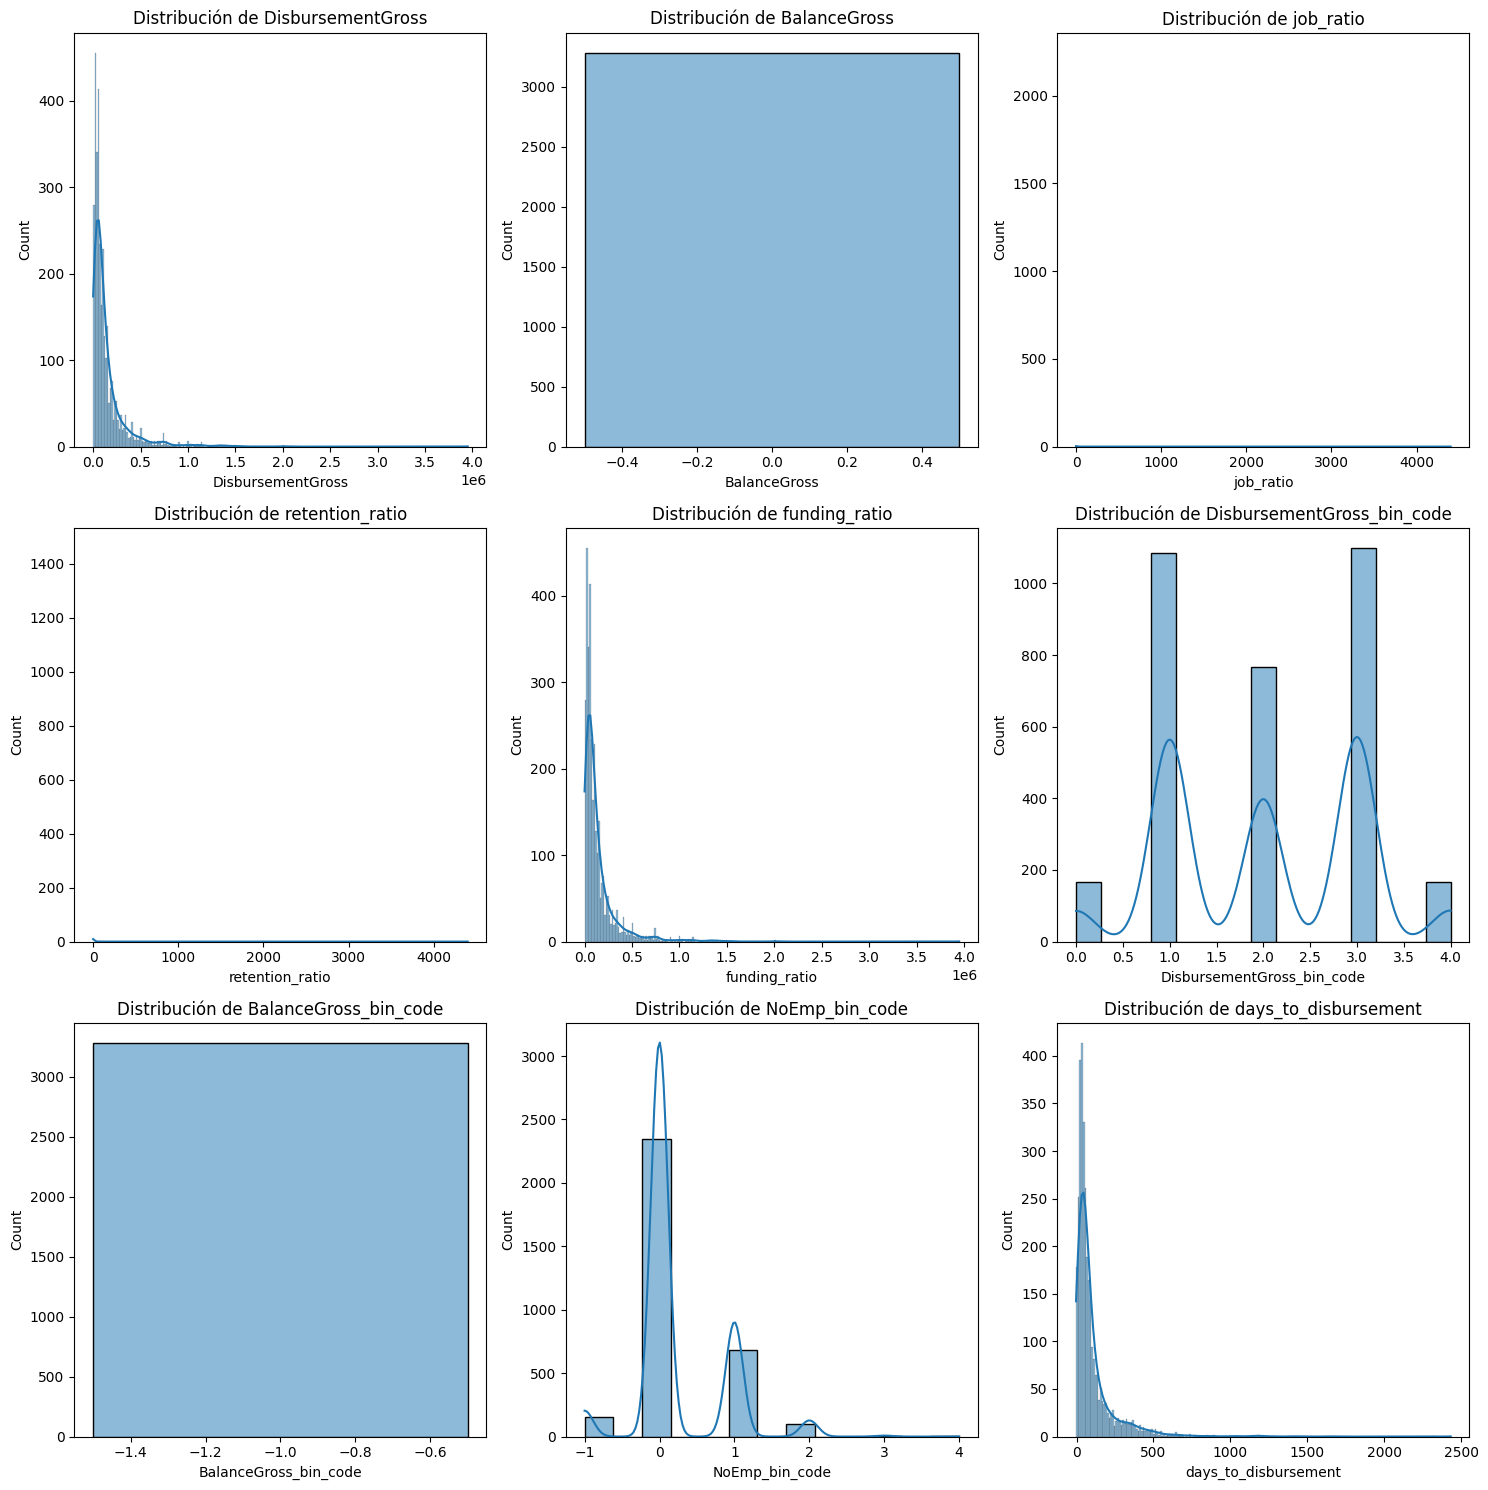

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=test

# Asegurarse de que los bins fueron creados correctamente
df['DisbursementGross_bin_code'] = pd.cut(df['DisbursementGross'], bins=[0, 10000, 50000, 100000, 500000, float('inf')],
                                           labels=[1, 2, 3, 4, 5]).cat.codes
df['BalanceGross_bin_code'] = pd.cut(df['BalanceGross'], bins=[0, 10000, 50000, 100000, 500000, float('inf')],
                                      labels=[1, 2, 3, 4, 5]).cat.codes
df['NoEmp_bin_code'] = pd.cut(df['NoEmp'], bins=[0, 10, 50, 250, 1000, float('inf')],
                              labels=[1, 2, 3, 4, 5]).cat.codes

# Selección de columnas numéricas relevantes para revisar
numeric_columns = ['DisbursementGross', 'BalanceGross', 'job_ratio', 'retention_ratio', 'funding_ratio', 
                   'DisbursementGross_bin_code', 'BalanceGross_bin_code', 'NoEmp_bin_code', 'days_to_disbursement']

# Histograma y boxplot para revisar distribuciones
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Distribución de {col}')
plt.tight_layout()

# Correlación entre variables numéricas y con la variable objetivo "Accept"
corr_matrix = df[numeric_columns + ['Accept']].corr()

# Mapa de calor de la correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlación entre características numéricas y 'Accept'")
plt.show()

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  3284 non-null   int64         
 1   id                          3284 non-null   object        
 2   LoanNr_ChkDgt               3284 non-null   int64         
 3   Name                        3284 non-null   object        
 4   City                        3284 non-null   object        
 5   Bank                        3284 non-null   object        
 6   BankState                   3284 non-null   object        
 7   ApprovalDate                3284 non-null   datetime64[ns]
 8   ApprovalFY                  3284 non-null   int64         
 9   NoEmp                       3284 non-null   int64         
 10  NewExist                    3284 non-null   float64       
 11  CreateJob                   3284 non-null   int64       